In [10]:
# ==============================
# 🔍 Сравнение 3 моделей на двух датасетах: YOLOv8, Faster R-CNN, RetinaNet
# ==============================

import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torchvision.ops import box_iou
from torchvision.models.detection import fasterrcnn_resnet50_fpn, retinanet_resnet50_fpn
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [11]:

DATASETS = {
    "rain_croud": {
        "IMAGES_DIR": "test/rain_croud/images",
        "LABELS_DIR": "test/rain_croud/labels",
    },
    "rain_person": {
        "IMAGES_DIR": "test/rain_person/images",
        "LABELS_DIR": "test/rain_person/labels",
    },
}

In [12]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor()])


In [13]:

def read_yolo_labels(label_path, img_w, img_h):
    boxes = []
    if not os.path.exists(label_path):
        return torch.zeros((0, 4))
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            _, x, y, w, h = map(float, parts)
            x1 = (x - w / 2) * img_w
            y1 = (y - h / 2) * img_h
            x2 = (x + w / 2) * img_w
            y2 = (y + h / 2) * img_h
            boxes.append([x1, y1, x2, y2])
    return torch.tensor(boxes)


In [14]:

def evaluate_model(pred_boxes, gt_boxes, iou_thresh=0.5):
    if len(gt_boxes) == 0 and len(pred_boxes) == 0:
        return 1, 1, 1, 1
    if len(gt_boxes) == 0 or len(pred_boxes) == 0:
        return 0, 0, 0, 0

    iou = box_iou(pred_boxes, gt_boxes)
    tp = (iou > iou_thresh).any(1).sum().item()
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    mAP50 = iou[iou > 0.5].mean().item() if (iou > 0.5).any() else 0
    return precision, recall, f1, mAP50


In [15]:

def avg_metrics(results):
    arr = np.array(results)
    return dict(
        precision=arr[:, 0].mean(),
        recall=arr[:, 1].mean(),
        f1=arr[:, 2].mean(),
        mAP50=arr[:, 3].mean()
    )


In [16]:

print("📦 Загрузка моделей...")
yolo_model = YOLO("yolov8n.pt")  # или путь к своей модели
faster_rcnn = fasterrcnn_resnet50_fpn(weights="DEFAULT").to(device).eval()
retinanet = retinanet_resnet50_fpn(weights="DEFAULT").to(device).eval()

all_results = []

📦 Загрузка моделей...


In [17]:

for dataset_name, paths in DATASETS.items():
    print(f"\n🚀 Оценка моделей на датасете: {dataset_name}")
    IMAGES_DIR = paths["IMAGES_DIR"]
    LABELS_DIR = paths["LABELS_DIR"]

    yolo_metrics, faster_rcnn_metrics, retinanet_metrics = [], [], []

    for img_name in sorted(os.listdir(IMAGES_DIR)):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(IMAGES_DIR, img_name)
        label_path = os.path.join(LABELS_DIR, os.path.splitext(img_name)[0] + ".txt")

        img = Image.open(img_path).convert("RGB")
        gt_boxes = read_yolo_labels(label_path, img.width, img.height)
        img_tensor = transform(img).to(device)

        # === YOLOv8 ===
        results = yolo_model.predict(source=img_path, verbose=False)
        pred_boxes_yolo = []
        for box, cls in zip(results[0].boxes.xyxy.cpu().numpy(), results[0].boxes.cls.cpu().numpy()):
            if int(cls) == 0:  # класс 0 = "person" в COCO
                pred_boxes_yolo.append(box[:4])
        pred_boxes_yolo = torch.tensor(pred_boxes_yolo)
        yolo_metrics.append(evaluate_model(pred_boxes_yolo, gt_boxes))
        
        # === Faster R-CNN ===
        with torch.no_grad():
            preds_rcnn = faster_rcnn([img_tensor])[0]
        # класс 1 = "person" в COCO
        mask = (preds_rcnn["labels"] == 1) & (preds_rcnn["scores"] > 0.5)
        pred_boxes_rcnn = preds_rcnn["boxes"][mask].cpu()
        faster_rcnn_metrics.append(evaluate_model(pred_boxes_rcnn, gt_boxes))
        
        # === RetinaNet ===
        with torch.no_grad():
            preds_retina = retinanet([img_tensor])[0]
        mask = (preds_retina["labels"] == 1) & (preds_retina["scores"] > 0.5)
        pred_boxes_retina = preds_retina["boxes"][mask].cpu()
        retinanet_metrics.append(evaluate_model(pred_boxes_retina, gt_boxes))

    # Средние метрики для датасета
    results_df = pd.DataFrame([
        {"Dataset": dataset_name, "Model": "YOLOv8", **avg_metrics(yolo_metrics)},
        {"Dataset": dataset_name, "Model": "Faster R-CNN", **avg_metrics(faster_rcnn_metrics)},
        {"Dataset": dataset_name, "Model": "RetinaNet", **avg_metrics(retinanet_metrics)},
    ])
    all_results.append(results_df)


🚀 Оценка моделей на датасете: rain_croud

🚀 Оценка моделей на датасете: rain_person



📊 Итоговые результаты по всем датасетам:


,Dataset,Model,precision,recall,f1,mAP50
0,rain_croud,YOLOv8,0.901685,0.843869,0.863118,0.755425
1,rain_croud,Faster R-CNN,0.737435,0.901408,0.798963,0.739530
2,rain_croud,RetinaNet,0.950018,0.747600,0.825524,0.755890
3,rain_person,YOLOv8,0.906976,0.976743,0.930231,0.769038
4,rain_person,Faster R-CNN,0.717054,0.999999,0.796566,0.829845
5,rain_person,RetinaNet,0.999999,0.999999,0.999999,0.842908


/Users/nikitaradcenko/Documents/TMS-Courses/People_recognison/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


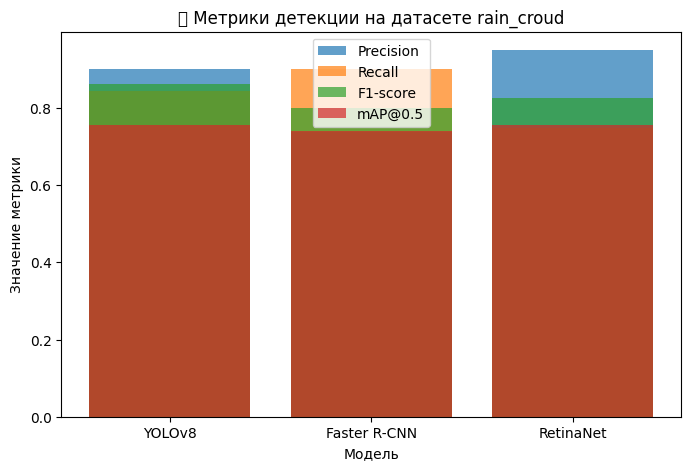

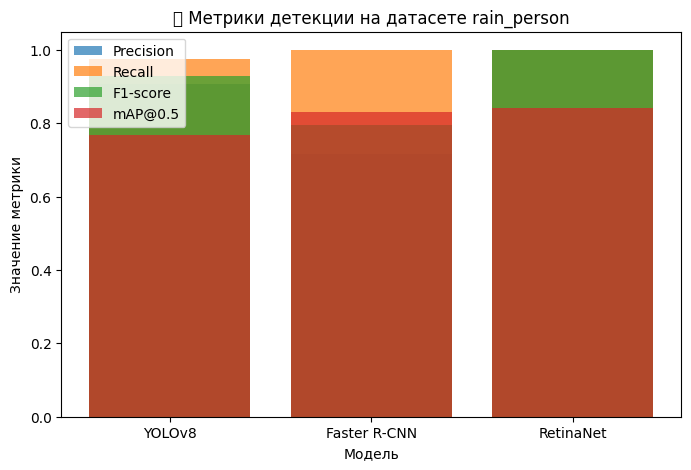

In [18]:

final_results = pd.concat(all_results, ignore_index=True)
print("\n📊 Итоговые результаты по всем датасетам:")
display(final_results)

for dataset_name in final_results["Dataset"].unique():
    df = final_results[final_results["Dataset"] == dataset_name]
    plt.figure(figsize=(8, 5))
    plt.bar(df["Model"], df["precision"], alpha=0.7, label="Precision")
    plt.bar(df["Model"], df["recall"], alpha=0.7, label="Recall")
    plt.bar(df["Model"], df["f1"], alpha=0.7, label="F1-score")
    plt.bar(df["Model"], df["mAP50"], alpha=0.7, label="mAP@0.5")
    plt.title(f"📈 Метрики детекции на датасете {dataset_name}")
    plt.xlabel("Модель")
    plt.ylabel("Значение метрики")
    plt.legend()
    plt.show()
